In [ ]:
# !unzip -n "DATA/classification-of-short-noisy-audio-speech.zip" -d "DATA/"
# !unzip -n "/home/ipynb/notebooks/wav2vec2/DATA/train_not_noise.zip" -d "/home/ipynb/notebooks/wav2vec2/DATA/"

# 1. Загрузка и установка бибилотек. Установка параметров

In [ ]:
# !pip install transformers
# !pip install librosa
# !pip install datasets
# !pip install nlpaug
# !git clone https://github.com/facebookresearch/denoiser
# !pip install julius

In [ ]:
import nlpaug.augmenter.audio as naa
from nlpaug.util.audio.visualizer import AudioVisualizer
import librosa
import librosa.display as librosa_display
import matplotlib.pyplot as plt
from types import SimpleNamespace
from datasets import load_dataset, load_metric, Dataset, DatasetDict, concatenate_datasets
import random
from IPython.display import display, Audio
from transformers import AutoFeatureExtractor
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook
import os
# from google.colab import files, drive
import soundfile as sf
import torch
from pathlib import Path
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

In [ ]:
# drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
params = SimpleNamespace()
params.sr = 16000 #sample rate
params.model_chekpoint = "OthmaneJ/distil-wav2vec2"
params.batch_size = 64
params.max_duration = 1.0
params.PATH_TO_NOISE = '/home/ipynb/notebooks/wav2vec2/DATA/hackaton_ds/train/'
params.PATH_NOT_NOISE = '/home/ipynb/notebooks/wav2vec2/DATA/train/'

params.PATH_TEST = '/home/ipynb/notebooks/wav2vec2/DATA/hackaton_ds/test'
params.PATH_NOT_NOISE_TEST = '/home/ipynb/notebooks/wav2vec2/DATA/test/'

params.SAVE_PATH = '/home/ipynb/notebooks/wav2vec2/DATA/'
params.CLASS_NAMES2ID = {'yes':0, 'no':1, 'up':2, 'down':3, 'left':4, 'right':5, 'on':6, 'off':7, 'stop':8, 'go':9}
params.ID2CLASS_NAMES = {0:'yes', 1:'no', 2:'up', 3:'down', 4:'left', 5:'right', 6:'on', 7:'off', 8:'stop', 9:'go'}

# 2. Загрузка и обработка данных

## 2.1. Очистка файлов от шума

In [ ]:
# %cd ./denoiser

In [ ]:
# for class_folder in tqdm_notebook(os.listdir(params.PATH_NOT_NOISE)):
#     dir_noise = params.PATH_NOT_NOISE + class_folder
#     dir_not_noise = params.PATH_NOT_NOISE + class_folder
#     !python -m denoiser.enhance --master64 --noisy_dir=$dir_noise --out_dir=$dir_not_noise --device 'cuda'

## 2.2. Загрузка файлов из папки

In [ ]:
def load_audiodata(load_path):
    audio_dataset = {}            
    for class_files in tqdm_notebook(os.listdir(load_path)):     
        for audio_file in tqdm_notebook(os.listdir(os.path.join(load_path, class_files))):
            # if 'enhanced.wav' in (audio_file.split('_')):
            array_file, _ = librosa.load(os.path.join(load_path, class_files, audio_file), sr=16000)
            if class_files in params.CLASS_NAMES2ID.keys():
                label_audio = params.CLASS_NAMES2ID[class_files]
            elif class_files == '_background_noise_':
                label_audio = params.CLASS_NAMES2ID['_silence_']
            else:
                label_audio = params.CLASS_NAMES2ID['_unknown_']
            try:
                audio_dataset['input_values'].append(array_file)
                audio_dataset['label'].append(label_audio)
            except:
                audio_dataset['input_values'] = [array_file]
                audio_dataset['label'] = [label_audio]                
    return audio_dataset

In [ ]:
train_dataset = load_audiodata(params.PATH_TO_NOISE)

<ipython-input-8-3b8cf3756cb1>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for class_files in tqdm_notebook(os.listdir(load_path)):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-8-3b8cf3756cb1>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for audio_file in tqdm_notebook(os.listdir(os.path.join(load_path, class_files))):


  0%|          | 0/8895 [00:00<?, ?it/s]

  0%|          | 0/8875 [00:00<?, ?it/s]

  0%|          | 0/8820 [00:00<?, ?it/s]

  0%|          | 0/8875 [00:00<?, ?it/s]

  0%|          | 0/8910 [00:00<?, ?it/s]

  0%|          | 0/8925 [00:00<?, ?it/s]

  0%|          | 0/8905 [00:00<?, ?it/s]

  0%|          | 0/8835 [00:00<?, ?it/s]

  0%|          | 0/8845 [00:00<?, ?it/s]

  0%|          | 0/8905 [00:00<?, ?it/s]

In [ ]:
train_dataset = Dataset.from_dict(train_dataset)

## 2.3. Аугментация данных

In [ ]:
def get_augmentated_data(x):

    x = np.array(x)
    rnd = random.randint(0, 2)
    if rnd == 0:
        aug = naa.CropAug(sampling_rate=params.sr)
        x_aug = aug.augment(x)
    elif rnd == 1:
        aug = aug = naa.LoudnessAug()
        x_aug = aug.augment(x)
    elif rnd == 2:
        aug = naa.MaskAug(sampling_rate=params.sr, mask_with_noise=False)
        x_aug = aug.augment(x)
    # elif rnd == 3:
    #     aug = naa.PitchAug(sampling_rate=params.sr, factor=(2,3))
    #     x_aug = aug.augment(x)
    return list(x_aug.astype('float32'))

In [ ]:
aug_dataset = dict()
aug_dataset['label'] = []
aug_dataset['input_values'] = []

for el in tqdm_notebook(train_dataset):
    aug_dataset['label'].append(el['label'])
    aug_dataset['input_values'].append(get_augmentated_data(el['input_values']))

<ipython-input-12-70afcb0fb675>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for el in tqdm_notebook(train_dataset):


  0%|          | 0/88790 [00:00<?, ?it/s]

In [ ]:
aug_dataset = Dataset.from_dict(aug_dataset)

In [ ]:
aug_train_dataset = concatenate_datasets([train_dataset, aug_dataset])
aug_train_dataset

## 2.4. Преобразование данных в наборы для обучения

In [ ]:
metric = load_metric("accuracy")
feature_extractor = AutoFeatureExtractor.from_pretrained(params.model_chekpoint)
params.sr = feature_extractor.sampling_rate
feature_extractor

In [ ]:
def preprocess_function(examples):
    audio_arrays = [x for x in examples["input_values"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=params.sr,
        max_length = int(params.sr * params.max_duration),
        truncation=True,
    )
    return inputs

In [ ]:
# load_from_cache_file=False
aug_train_dataset = aug_train_dataset.map(preprocess_function, batched=True)
aug_train_dataset

In [ ]:
aug_train_dataset.to_csv(params.SAVE_PATH+'aug_train_dataset.csv')

# 3. Обучение

In [ ]:
# params.model_chekpoint = '/home/ipynb/notebooks/wav2vec2/distil-wav2vec2-finetuned-ks-noised/checkpoint-6930'
num_labels = len(params.CLASS_NAMES2ID)
model = AutoModelForAudioClassification.from_pretrained(
    params.model_chekpoint,
    num_labels=num_labels,
    label2id=params.CLASS_NAMES2ID,
    id2label=params.ID2CLASS_NAMES,
)

In [ ]:
model_name = params.model_chekpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-ks-noised_aug",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 3e-5,
    per_device_train_batch_size=params.batch_size,
    gradient_accumulation_steps = 4,
    per_device_eval_batch_size=params.batch_size,
    num_train_epochs=2,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    lr_scheduler_type = "constant_with_warmup"
    # push_to_hub=True,
)

In [ ]:
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

# 6. Получение предсказаний модели

In [ ]:
sample_csv = pd.read_csv(params.SAVE_PATH + 'sample.csv')
sample_csv

,id,category
0,5d03214e74f5ea475b22,yes
1,686ad9e641964142b6b0,yes
2,eec1364a587997161bb8,yes
3,8fb7ede79446ad22c60f,yes
4,de573903106ba3524064,yes
...,...,...
29615,05ae7715e1499b5a72c8,yes
29616,2e14d09dad51733d4658,yes
29617,267a9b10c2a33d67f084,yes
29618,341143991403fd8ae3c6,yes


In [ ]:
def load_audiodata_for_submit(load_path):
    audio_dataset = {}   
    for audio_file in tqdm_notebook(os.listdir(load_path)):
        #if 'enhanced.wav' in (audio_file.split('_')):
        array_file, _ = librosa.load(os.path.join(load_path, audio_file), sr=16000)        
        try:
            audio_dataset['input_values'].append(array_file)
            audio_dataset['id'].append(audio_file.split('.')[0])           
        except:
            audio_dataset['input_values'] = [array_file]
            audio_dataset['id'] = [audio_file.split('.')[0]]                           
    return audio_dataset

pred_data = load_audiodata_for_submit(params.PATH_TEST)

def preprocess_function2(examples):
    audio_arrays = [x for x in examples]
    inputs = feature_extractor(
        audio_arrays, 
        sampling_rate=feature_extractor.sampling_rate, 
        max_length=int(feature_extractor.sampling_rate * params.max_duration), 
        truncation=True, 
    )
    return inputs

pred_data['input_values'] = preprocess_function2(pred_data['input_values'])['input_values']

pred_data_for_model = Dataset.from_dict(pred_data)
dict_predict = trainer.predict(pred_data_for_model)
pred_data['predict'] = np.argmax(dict_predict.predictions, axis=1)
pd_pred_data = pd.DataFrame.from_dict(pred_data)
pd_pred_data['category'] = pd_pred_data.predict.apply(lambda x: params.ID2CLASS_NAMES[x])
pd_pred_data.drop(labels=['input_values', 'predict'], axis=1).to_csv(params.SAVE_PATH + 'submission_aug.csv', index=False)
pd_pred_data.to_csv('DATA/pd_pred_data_aug.csv')

<ipython-input-18-f8000519b5a1>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for audio_file in tqdm_notebook(os.listdir(load_path)):


  0%|          | 0/29620 [00:00<?, ?it/s]

/opt/anaconda3/envs/zhuk/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
The following columns in the test set  don't have a corresponding argument in `Wav2Vec2ForSequenceClassification.forward` and have been ignored: id.
***** Running Prediction *****
  Num examples = 29620
  Batch size = 32


In [ ]:
# # так как среда зависла, то загружаю метки из сабмита
# def get_label(x):
#     return params.CLASS_NAMES2ID[x]

# sub_df = pd.DataFrame(params.SAVE_PATH + 'submission.csv')
# sub_df['label'] = sub_df['pred'].apply(get_label)

# def load_audiodata_for_submit(load_path):
#     audio_dataset = {}   
#     for audio_file in tqdm_notebook(os.listdir(load_path)):
#         #if 'enhanced.wav' in (audio_file.split('_')):
#         array_file, _ = librosa.load(os.path.join(load_path, audio_file), sr=16000)        
#         try:
#             audio_dataset['input_values'].append(array_file)
#             audio_dataset['id'].append(audio_file.split('.')[0])           
#         except:
#             audio_dataset['input_values'] = [array_file]
#             audio_dataset['id'] = [audio_file.split('.')[0]]                           
#     return audio_dataset

# prep_data = load_audiodata_for_submit(params.PATH_TEST)
# pred_data['label'] = sub_df['label'].values()
# new_train_dataset = Dataset.from_dict(pred_data)

# def preprocess_function2(examples):
#     audio_arrays = [x for x in examples]
#     inputs = feature_extractor(
#         audio_arrays, 
#         sampling_rate=feature_extractor.sampling_rate, 
#         max_length=int(feature_extractor.sampling_rate * params.max_duration), 
#         truncation=True, 
#     )
#     return inputs

# new_train_dataset = new_train_dataset.map(preprocess_function, batched=True)
# new_train_dataset.to_csv(params.SAVE_PATH+'new_train_dataset.csv')

In [ ]:
new_train_data = pd_pred_data[['input_values', 'predict']]
new_train_data.columns = ['input_values', 'label']
new_train_data = Dataset.from_pandas(new_train_data)
new_train_data

Dataset({
    features: ['input_values', 'label'],
    num_rows: 29620
})

In [ ]:
new_train_dataset = concatenate_datasets([train_dataset, new_train_data])

In [ ]:
new_train_dataset.to_csv(params.SAVE_PATH+'new_train_dataset.csv')

Creating CSV from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

10184635

In [ ]:
new_train_data[0]['input_values'][0]

In [ ]:
print(1)

In [ ]:
!zip -r /content/wav2vec2-base-finetuned-ks/checkpoint-1995.zip /content/wav2vec2-base-finetuned-ks/checkpoint-1995

  adding: content/wav2vec2-base-finetuned-ks/checkpoint-1995/ (stored 0%)
  adding: content/wav2vec2-base-finetuned-ks/checkpoint-1995/training_args.bin (deflated 48%)
  adding: content/wav2vec2-base-finetuned-ks/checkpoint-1995/optimizer.pt (deflated 9%)
  adding: content/wav2vec2-base-finetuned-ks/checkpoint-1995/config.json (deflated 66%)
  adding: content/wav2vec2-base-finetuned-ks/checkpoint-1995/pytorch_model.bin (deflated 7%)
  adding: content/wav2vec2-base-finetuned-ks/checkpoint-1995/trainer_state.json (deflated 85%)
  adding: content/wav2vec2-base-finetuned-ks/checkpoint-1995/preprocessor_config.json (deflated 33%)
  adding: content/wav2vec2-base-finetuned-ks/checkpoint-1995/scheduler.pt (deflated 50%)
  adding: content/wav2vec2-base-finetuned-ks/checkpoint-1995/rng_state.pth (deflated 28%)


In [ ]:
from google.colab import files
files.download("/content/wav2vec2-base-finetuned-ks/checkpoint-1995.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# !git clone https://github.com/facebookresearch/denoiser
# !pip install julius

In [ ]:
import soundfile as sf
y = dataset['train'][10]['audio']['array']
sf.write('/content/noised/stereo_file.wav', y, 16000, 'PCM_24')

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
cd /content/denoiser/
!python -m denoiser.enhance --master64 --noisy_dir='/content/noised/' --out_dir '/content/not_noised/' --device device

INFO:denoiser.pretrained:Loading pre-trained real time H=64 model trained on DNS and Valentini.
INFO:__main__:Generate enhanced files | 1/1 | 16.7 it/sec
Waiting for pending jobs...
INFO:__main__:Generate enhanced files | 1/1 | 2.3 it/sec


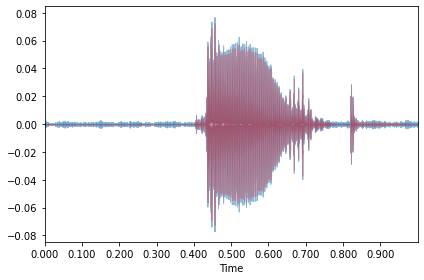

In [ ]:
y, sr = librosa.load('/content/noised/stereo_file.wav', sr=16000)
librosa_display.waveplot(y, sr=sr, alpha=0.5)
y, sr = librosa.load('/content/not_noised/stereo_file_enhanced.wav', sr=16000)
librosa_display.waveplot(y, sr=sr, color='r', alpha=0.25)

plt.tight_layout()
plt.show()

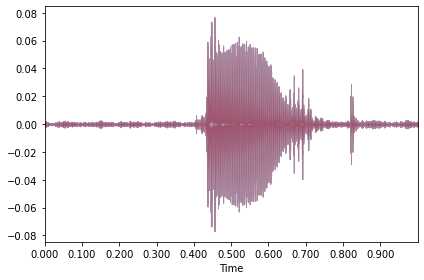

In [ ]:
y, sr = librosa.load('/content/noised/stereo_file.wav')
librosa_display.waveplot(y, sr=sr, alpha=0.5)
y, sr = librosa.load('/content/not_noised/stereo_file_noisy.wav')
librosa_display.waveplot(y, sr=sr, color='r', alpha=0.25)

plt.tight_layout()
plt.show()